<h1 align='center'>Ben Prescott - Assignment 4 Part 1</h1>

The activities in this notebook focus on implementing an autoencoder to generate word embeddings. The autoencoder hyperparameters will be tweaked to achieve the best performance, then used to create the embeddings for the XTrain, XVal and XTest data. 

In [3]:
#Creating an interactive shell so that every output is visible, not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Importing Required Libraries

In [38]:
import gc
import numpy as np
import tensorboard #including TensorBoard just for my own sake of visualization
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, RepeatVector, Dense, LeakyReLU
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from pickleshare import PickleShareDB
from plot_keras_history import plot_history 
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
#Defining the root directory for easier use late
root = 'C:/Users/bprescott/Documents/assignment-4/'    

## Loading "X Data" From Part 0 

In [6]:
db=PickleShareDB(root+'assign4.pshare')   #Defining the directory for my pickle databases
db.keys() #Grabbing the available ones in the folder

['emMat10000X100',
 'wordIndx',
 'XTest',
 'XTestEm',
 'XTrain',
 'XTrainEm',
 'XVal',
 'XValEm',
 'yTest',
 'yTrain',
 'yVal']

In [50]:
#Assigning the pickled files to active Python objects & reviewing shape
XTrain=db['XTrain']
XVal=db['XVal']
XTest=db['XTest']
XTrain.shape
XVal.shape
XTest.shape

(2000, 80)

(6000, 80)

(6000, 80)

## Building The Autoencoder Model

In this section I'll be building the autoencoder model using the Keras Functional API. The functional API allows us to be a bit more "fluid" in defining how the layers connect to others, in comparison to operating in order using the Sequential API. 

In [8]:
#Keeping standard hyperparameter values
maxLen=80 #Max character length of a review
maxWords=10000 #Max number of words
batch_size=32 #Batches from the training data. "chunks"
emDim=100 #Dimensions of the word embeddings. 100 in this case

In [63]:
clear_session() #clearing all previous model information
gc.collect() #freeing up memory

4774

The following section is defining the encoder and decoder portions of the autoencoder. As mentioned earlier, this method is using the Functional API, which is why it isn't as clean as a sequential "stacked" model. However, this provides more flexibility for model connections. 

#### Creating The Encoder Model

In [64]:
#Creating the input with shape of (None,80)
inputPadded=Input(shape=(maxLen,))
#creating the Embedding layer object using the earlier defined hyperparameters 
embedLayer=Embedding(maxWords,output_dim=emDim,input_length=maxLen) 
#creating the 3D tensor with shape (none,80,100)
x = embedLayer(inputPadded)
#Creating the a bidirectional LSTM layer with an output dimension of 32
#Also adding L2 regularization to aid in avoiding overfitting
#Adding the embedding layer as an input
state_hidden1=Bidirectional(LSTM(32, kernel_regularizer=l2(0.01)))(x)
#Creating a single LeakyReLU layer to replace the dense ReLU layer
#Helping to avoid exploding gradients, which was noticed with ReLU
#Connecting the LSTM layer as input
state_hidden2=LeakyReLU(alpha=0.2)(state_hidden1)
#Grouping the input and output layers to define the encoder
encodeM=Model(inputs=inputPadded,outputs=state_hidden2)
#Adding the encoder with input as the intended decoder output
decoderOut=encodeM(inputPadded)

In [75]:
#Viewing the encoder model
encodeM.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
Total params: 1,034,048
Trainable params: 1,034,048
Non-trainable params: 0
_________________________________________________________________


#### Creating The Decoder Model

In [65]:
#Creating a RepeatVector layer that will repeat the input 80 times. Example: (None, 80, 64)
decoded=RepeatVector(maxLen)(decoderOut)
#Creating a bidirectional LSTM layer, returning the sequences, not just the last output
#Also including L2 regularization
dec_lstm=Bidirectional(LSTM(32,return_sequences=True,kernel_regularizer=l2(0.01)))
#Adding the 'decoded' 3D tensor to the bidirectional LSTM layer to create a new 3D tensor
decoded_lstm_output=dec_lstm(decoded)
#creating a fully connected Dense layer with softmax activation to provide probabilities
dec_dense=Dense(maxWords,activation='softmax')
#adding the 3D tensor to the Dense layer
decoder_outputs=dec_dense(decoded_lstm_output)

In [66]:
#Creating the autoencoder using the encoder inputs through decoder outputs
autoEnc_Model=Model(inputPadded,decoder_outputs)

In [67]:
#Viewing the architecture of the autoencoder
autoEnc_Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
model (Functional)           (None, 64)                1034048   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 80, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 64)            24832     
_________________________________________________________________
dense (Dense)                (None, 80, 10000)         650000    
Total params: 1,708,880
Trainable params: 1,708,880
Non-trainable params: 0
_________________________________________________________________


## Training The Autoencoder

Now that the autoencoder architecture is defined I'll compile the model using the Nadam optimizer, a learning rate of 0.0001, and computing sparse_categorial_crossentropy loss. I'm also including callbacks to include logging for TensorBoard, as I am using TensorBoard to visualize the model. 

In [68]:
#Compiling the model w/ Nadam algorithm and initial learning rate of 0.0001
autoEnc_Model.compile(optimizer=Nadam(lr=0.0001),
                      loss='sparse_categorical_crossentropy'
                     )

In [69]:
#Creating some callbacks for use in the model training
callback=EarlyStopping(monitor='val_loss',patience=2) #stop if no change in loss over two epochs
logdir="C:/Users/bprescott/Documents/logs" + 'model2' #directory to store TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=logdir) #Used to save TensorBoard logs

Training the model showed what looked to be pretty good results. Test loss remained lower than training loss due to the regularization not being applied to the test/validation data, only training. I'll stick with 30 epochs and a batch size of 32, but training may stop earlier if no additional improvement in validation loss is found. 

In [70]:
#Training the autoencoder
history=autoEnc_Model.fit(XTrain,np.expand_dims(XTrain,-1),
                         batch_size=batch_size,
                         epochs=30,
                         validation_data=(XVal,XVal),
                         verbose=0,
                         callbacks=[callback, tensorboard_callback])

Using the `plot_history` function we can see the `EarlyStopping` callback stopped the model shy of the 30th epoch, as no additional improvement in validation loss was found. The best validation loss obtained is 6.6 and 6.5 for training loss. 

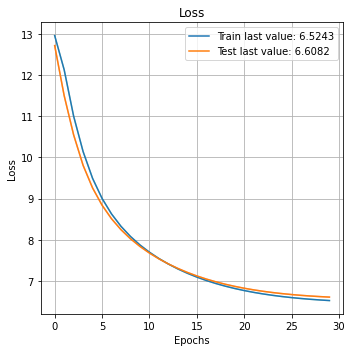

In [71]:
plot_history(history.history)

## Embedding Vector Generation

Now that I have a model that seems to have acceptable performance, I'll generate my X training embeddings using my trained autoencoder. 

In [158]:
#Predicting the XTrain embeddings
XTrainEm = encodeM.predict(XTrain)

In [164]:
#Reviewing the shape of the XTrain embeddings
print('Embedded train shape:',XTrainEm.shape)

Embedded train shape: (2000, 64)


## Generating Vectors for Validation and Test Data

I'll also be generating the embeddings for the X validation and X test data.

In [162]:
#Predicting the embeddings for XVal and XTest
XValEm = encodeM.predict(XVal)
XTestEm = encodeM.predict(XTest)

In [163]:
#Reviewing shape
print('Embedded validation shape:',XValEm.shape)
print('Embedded test shape:',XTestEm.shape)

Embedded validation shape: (6000, 64)
Embedded test shape: (6000, 64)


## Saving Embedded Data

Now that I have my embeddings I'll be saving them as pickled files to import into the next part of the assignment. 

In [166]:
#Reassigning the location for the saved files  
db4 = PickleShareDB(root+'/assign4.pshare')

['wordIndx', 'XTest', 'XTrain', 'XVal', 'yTest', 'yTrain', 'yVal']

In [167]:
#Saving the X data embeddings as files.
db4['XTrainEm']=XTrainEm
db4['XValEm']=XValEm
db4['XTestEm']=XTestEm